# Comparison of models using metrics

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import BertForMaskedLM, BertTokenizer, AutoTokenizer, AutoModelForSeq2SeqLM
import torch

import sys
sys.path.append('..')
from src.models.predict import detoxificate_text, detoxificate_text_with_classifier, detoxificate_style_transfer
from src.models.metrics import semantic_similarity, style_accuracy, fluency, j_metric
from src.models.classifier import ToxicWordsClassifier
from src.visualization.visualize import plot_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 1337
torch.manual_seed(RANDOM_SEED)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Loading all necessery data

In [2]:
BATCH_SIZE = 16

df = pd.read_csv('../data/interim/test.csv')
data = df['reference'].tolist()[:128]
labels = df['translation'].tolist()[:128]

data = [data[i:i + BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]
labels = [labels[i:i + BATCH_SIZE] for i in range(0, len(labels), BATCH_SIZE)]

### Loading all models

In [3]:
model_maskedlm = BertForMaskedLM.from_pretrained('../models/bert_maskedlm')
tokenizer_maskedlm = BertTokenizer.from_pretrained('../models/bert_maskedlm')

classifier = ToxicWordsClassifier(vocab_size=tokenizer_maskedlm.vocab_size, embedding_dim=512, dropout=0.3)
classifier.load_state_dict(torch.load('../models/toxicity_classifier.pth'))

model_seq2seq = AutoModelForSeq2SeqLM.from_pretrained('../models/detoxificator')
tokenizer_seq2seq = AutoTokenizer.from_pretrained('../models/detoxificator')

toxic_words = open('../data/interim/toxic_words.txt').read().split('\n')

### Testing the first hypothesis

In [4]:
sim = []
acc = []
flnc = []
j_score = []

for text, label in tqdm(zip(data, labels), total=len(data)):
    pred = detoxificate_text(text, toxic_words, tokenizer_maskedlm, model_maskedlm, 'cuda')
    sim.append(semantic_similarity(pred, label))
    acc.append(style_accuracy(pred))
    flnc.append(fluency(pred))
    j_score.append(j_metric(sim[-1], acc[-1], flnc[-1]))

maskedlm = {}
maskedlm['SIM'] = np.mean(sim)
maskedlm['ACC'] = np.mean(acc)
maskedlm['FLNC'] = np.mean(flnc)
maskedlm['J'] = np.mean(j_score)

100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


In [5]:
maskedlm

{'SIM': 0.79685104, 'ACC': 0.8215981, 'FLNC': 0.7199023, 'J': 0.4743987}

### Testing the second hypothesis

In [6]:
sim = []
acc = []
flnc = []
j_score = []

for text, label in tqdm(zip(data, labels), total=len(data)):
    pred = detoxificate_text_with_classifier(text, tokenizer_maskedlm, model_maskedlm, classifier, 'cuda')
    sim.append(semantic_similarity(pred, label))
    acc.append(style_accuracy(pred))
    flnc.append(fluency(pred))
    j_score.append(j_metric(sim[-1], acc[-1], flnc[-1]))

maskedlm_with_classifier = {}
maskedlm_with_classifier['SIM'] = np.mean(sim)
maskedlm_with_classifier['ACC'] = np.mean(acc)
maskedlm_with_classifier['FLNC'] = np.mean(flnc)
maskedlm_with_classifier['J'] = np.mean(j_score)

100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


In [7]:
maskedlm_with_classifier

{'SIM': 0.766516, 'ACC': 0.7130087, 'FLNC': 0.6344938, 'J': 0.34953815}

### Testing the third hypothesis

In [8]:
sim = []
acc = []
flnc = []
j_score = []

for text, label in tqdm(zip(data, labels), total=len(data)):
    pred = detoxificate_style_transfer(text, model_seq2seq, tokenizer_seq2seq, 'cuda')
    sim.append(semantic_similarity(pred, label))
    acc.append(style_accuracy(pred))
    flnc.append(fluency(pred))
    j_score.append(j_metric(sim[-1], acc[-1], flnc[-1]))

style_transfer = {}
style_transfer['SIM'] = np.mean(sim)
style_transfer['ACC'] = np.mean(acc)
style_transfer['FLNC'] = np.mean(flnc)
style_transfer['J'] = np.mean(j_score)

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


In [9]:
style_transfer

{'SIM': 0.8737449, 'ACC': 0.63149583, 'FLNC': 0.88829887, 'J': 0.48831818}

### Visualizing the results

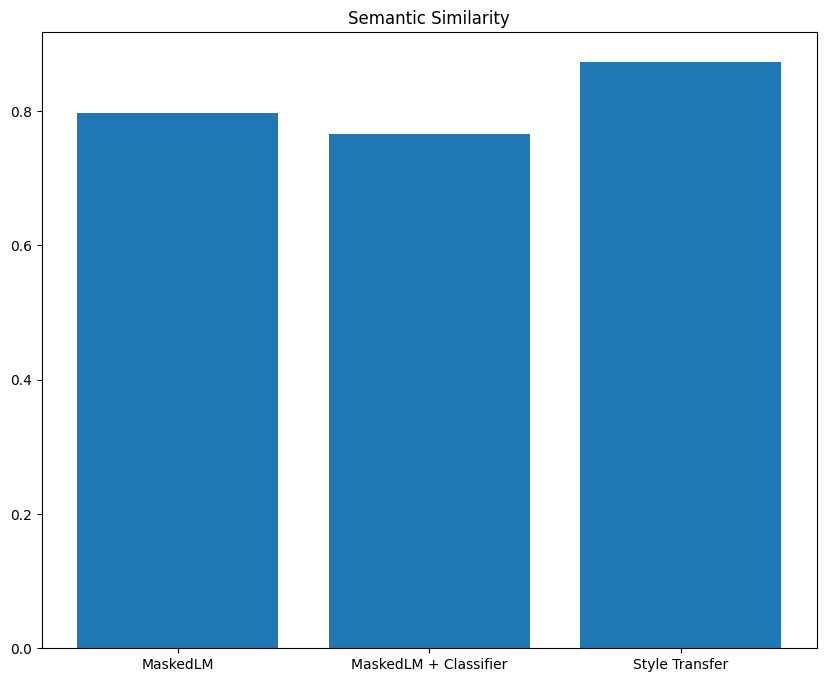

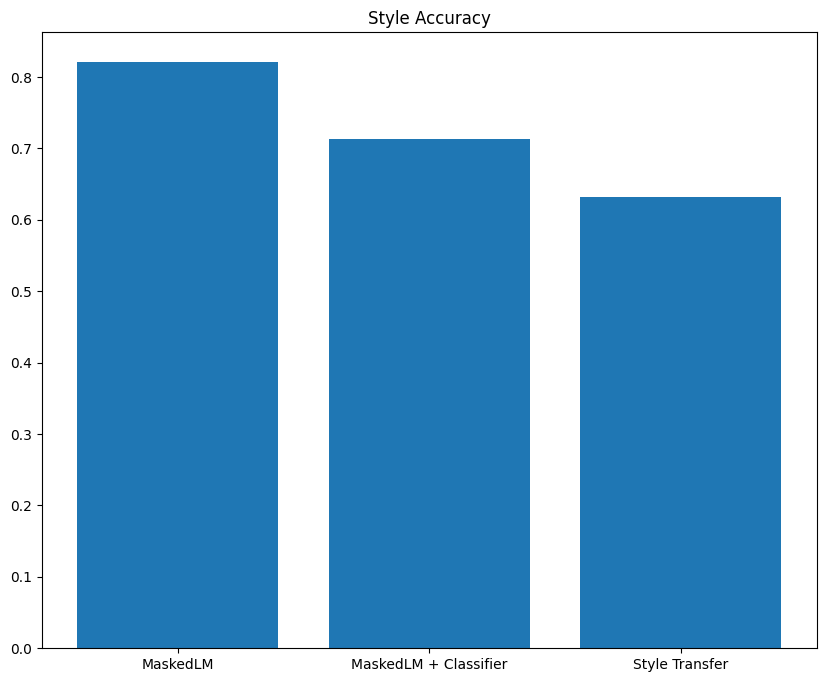

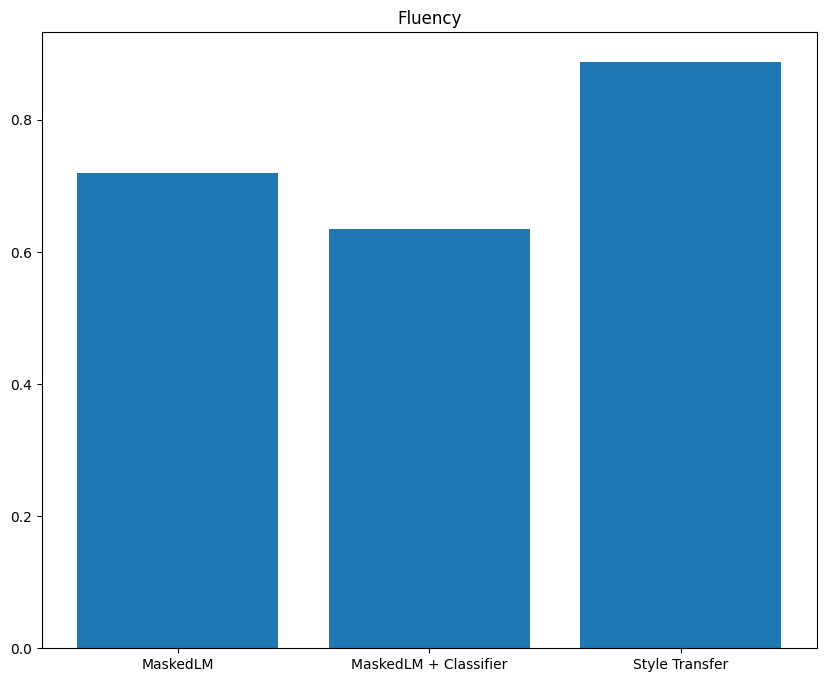

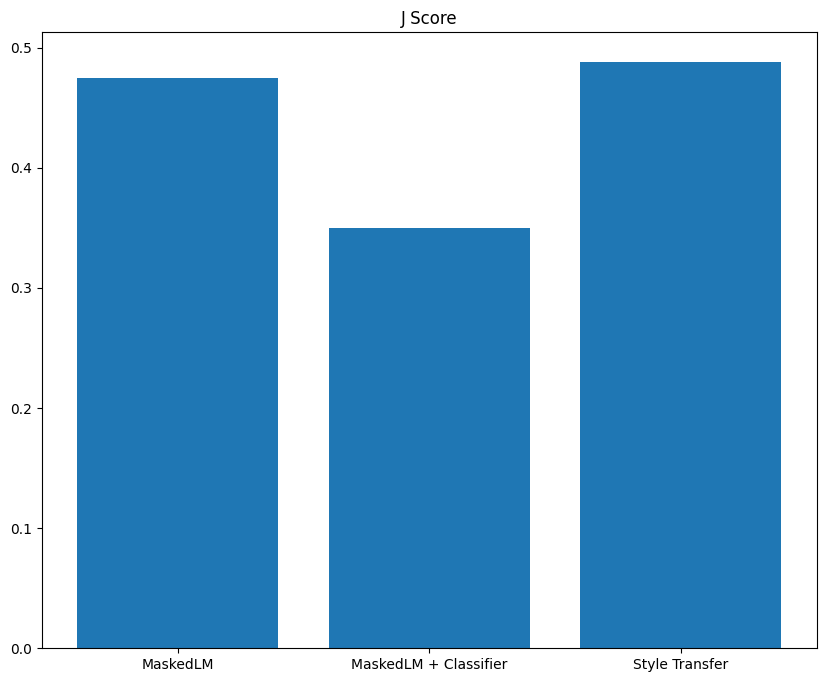

In [10]:
data = {'MaskedLM': maskedlm, 'MaskedLM + Classifier': maskedlm_with_classifier, 'Style Transfer': style_transfer}
plot_metrics(data)